Загрузка модулей

In [1]:
%matplotlib inline

from re import sub, compile
from pandas import DataFrame, Series
import numpy as np
import seaborn as sns
from pylab import rcParams, savefig
import matplotlib
from gensim import models, corpora
from gensim.utils import tokenize
from itertools import chain
from nltk import sent_tokenize
from nltk.tokenize import wordpunct_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from pickle import load
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
morph = MorphAnalyzer()
from joblib import Parallel, delayed

In [2]:
BOARD = 'b'

In [ ]:
stop = {'весь', 'всякий', 'тот', 'это', 'самое', 'каким', 'сама', 'никак', 'она', 'она', 'оно', 'какие', 'какого', 'которая', 'многое', 'чему', 'всему', 'раза', 'сразу', 'весь', 'раз', 'пор', 'например', 'вроде', 'которые', 'который', 'просто', 'очень', 'почему', 'вообще', 'ещё', 'типа', 'ради', 'всё', 'хотя', 'тебе', 'нужно', 'пока',
, 'сделать', 'можешь', 'могу', 'могут', 'делать', 'будешь', 'быть', 'будут', 'смочь', 'поэтому'}

Загрузка регулярок

In [5]:
from re import sub, compile

def cut(data):
    r = compile(r'<.*?>|>>\d*|\(OP\)|&#(\d*);|&quot;|&gt;|(http|https):.*')
    return r.sub('', punctuate_word(punctuate_sent((data))))

def punctuate_sent(data):
    r = compile(r'([a-zA-Zа-яА-Я])([.!\?])')
    return r.sub(r'\1. ', data)

def punctuate_word(data):
    r = compile(r'([a-zA-Zа-яА-Я])([,])')
    return r.sub(r'\1, ', data)

def pos_cut(s):
    s = sub(r"ADJF", "ADJ", s)
    s = sub(r"ADVB", "ADV", s)
    s = sub(r"INFN", "VERB", s)
    return s

def topic_cut(word):
    return sub('[^a-zA-Zа-яА-Я]', '', word)

def check_for_rus_lan(word):
    regex = compile('[А-Яа-я]+$')
    if regex.match(word):
        return True
    return False

def check_dirty(word):
    regexp = compile(r'уеб|хуё|ёб|пидо|иби|хуй|еба|бля|еби|хуе|хуи|пиз|срал|velf|оеб|ебаш')
    if regexp.search(word):
          return True
    return False

Загрузка вектора длин постов

In [3]:
posts_lengths = []
posts_lengths += load(open('pickle/' + BOARD + '_posts_lengths.pickle', 'rb'))

Отрисовка графика длин постов

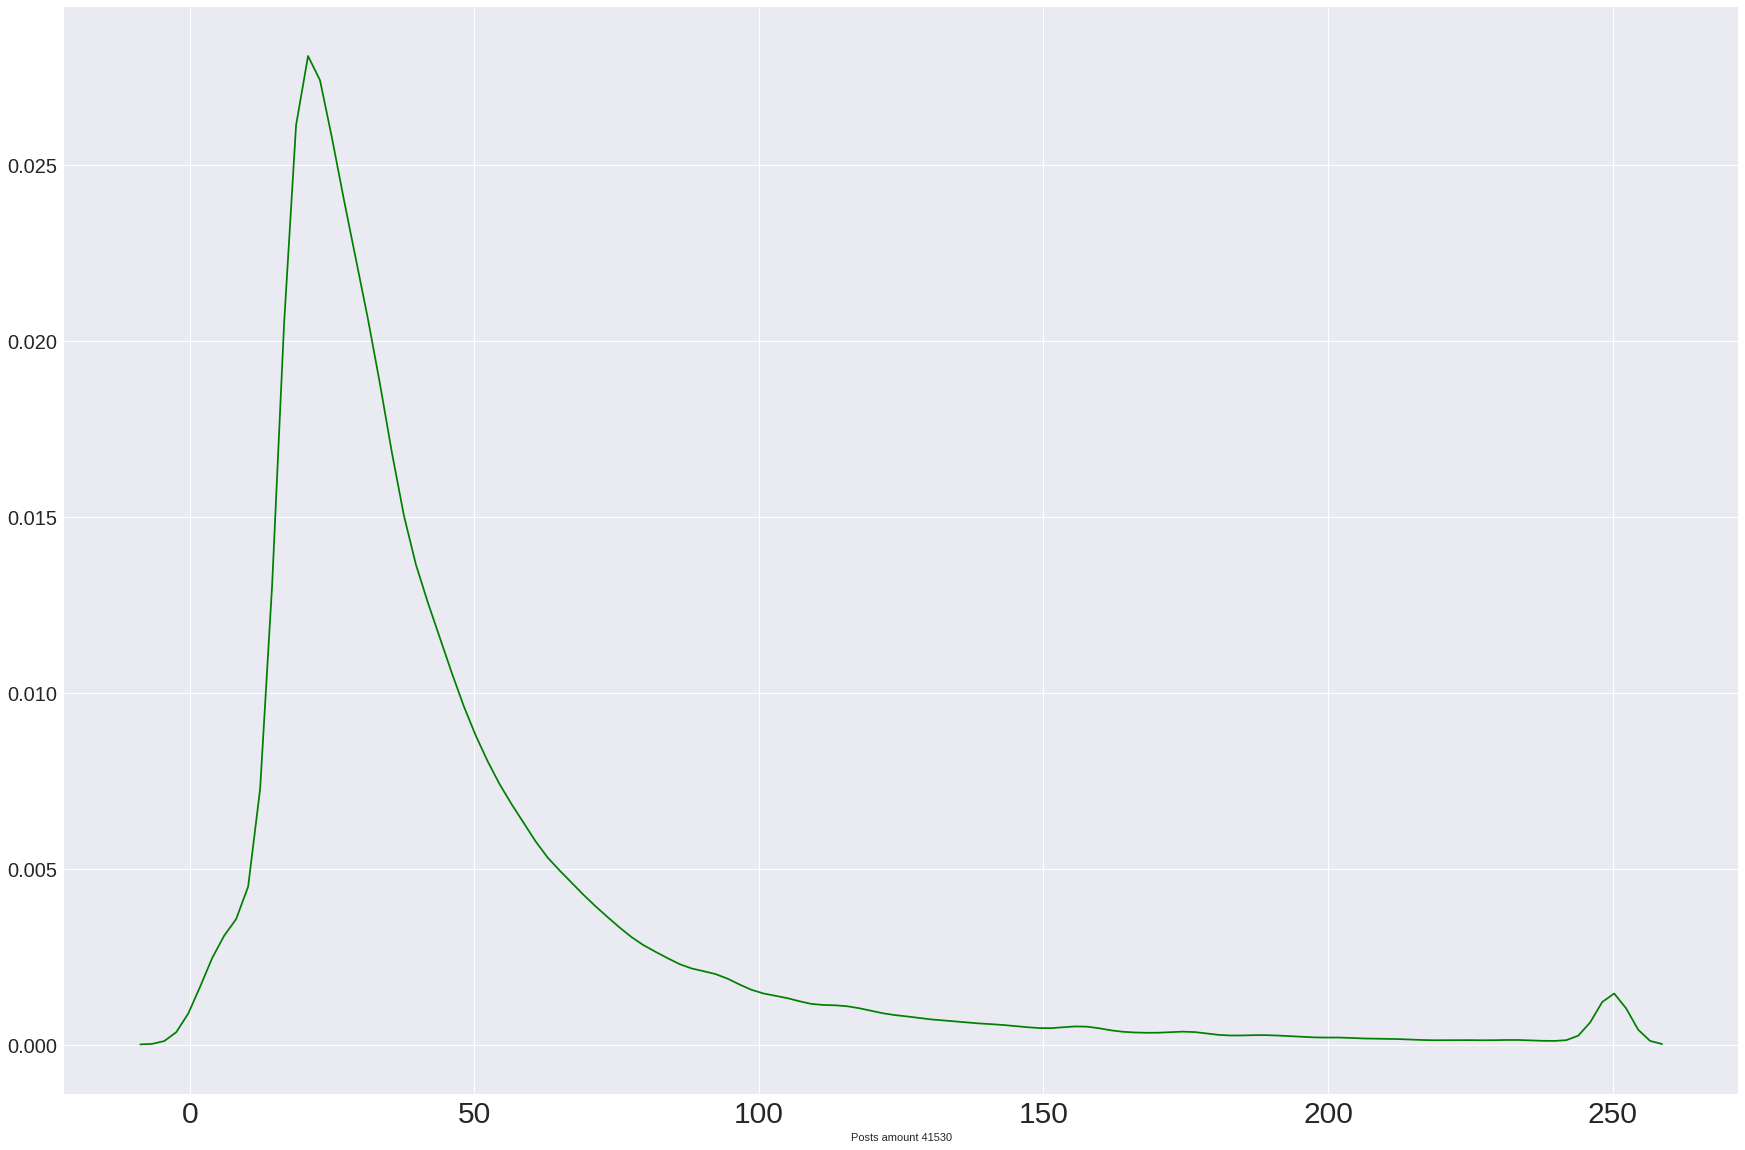

In [4]:
rcParams['figure.figsize'] = 30, 20
params = {'xtick.labelsize': 30, 'ytick.labelsize': 20}
matplotlib.rcParams.update(params)

posts_lengths = posts_lengths[1:]
len(posts_lengths)

x = pd.Series(posts_lengths, name = 'Posts amount ' + str(len(posts_lengths)))
sns.distplot(x, bins=100, rug=False, hist=False, color='green')
savefig('pr_graph.png')

Загрузка коллекции текстовых сообщений

In [3]:
texts = []
texts += load(open('pickle/' + BOARD + '.pickle', 'rb'))
texts = [str(text).lower() for text in texts]

Формирование словаря из коллекции

In [14]:
words_dict = {}

for text in texts:
    for word in tokenize(text):
        normal_word = morph.parse(word)[0].normal_form
        if len(word) > 2 and not check_dirty(word) and str(morph.parse(word)[0].methods_stack[0][0]) == '<FakeDictionary>':
            if normal_word not in words_dict:
                words_dict[normal_word] = 0
            else:
                words_dict[normal_word] += 1

Определение числа слов в коллекции

In [15]:
lengths = [(len(list(tokenize(text)))) for text in texts]
words_amount = sum(lengths)

Формирование из словаря датафрейма

In [16]:
df = DataFrame.from_dict(words_dict, orient='index').reset_index()
df.columns = ['word', 'frequency']
df = df.sort_values(by=['frequency', 'word'], ascending=False).reset_index()
percentage = []
for i in df.frequency:
    percentage.append(round(i/words_amount*100,4))
df['percentage'] = Series(percentage, index=df.index)

In [22]:
df = df.drop(df.index[[1]]).reset_index(drop=True)

In [38]:
df.to_csv('mnsk_test.csv')

Отрисовка диаграммы с наиболее частоупотребимыми словами в словаре

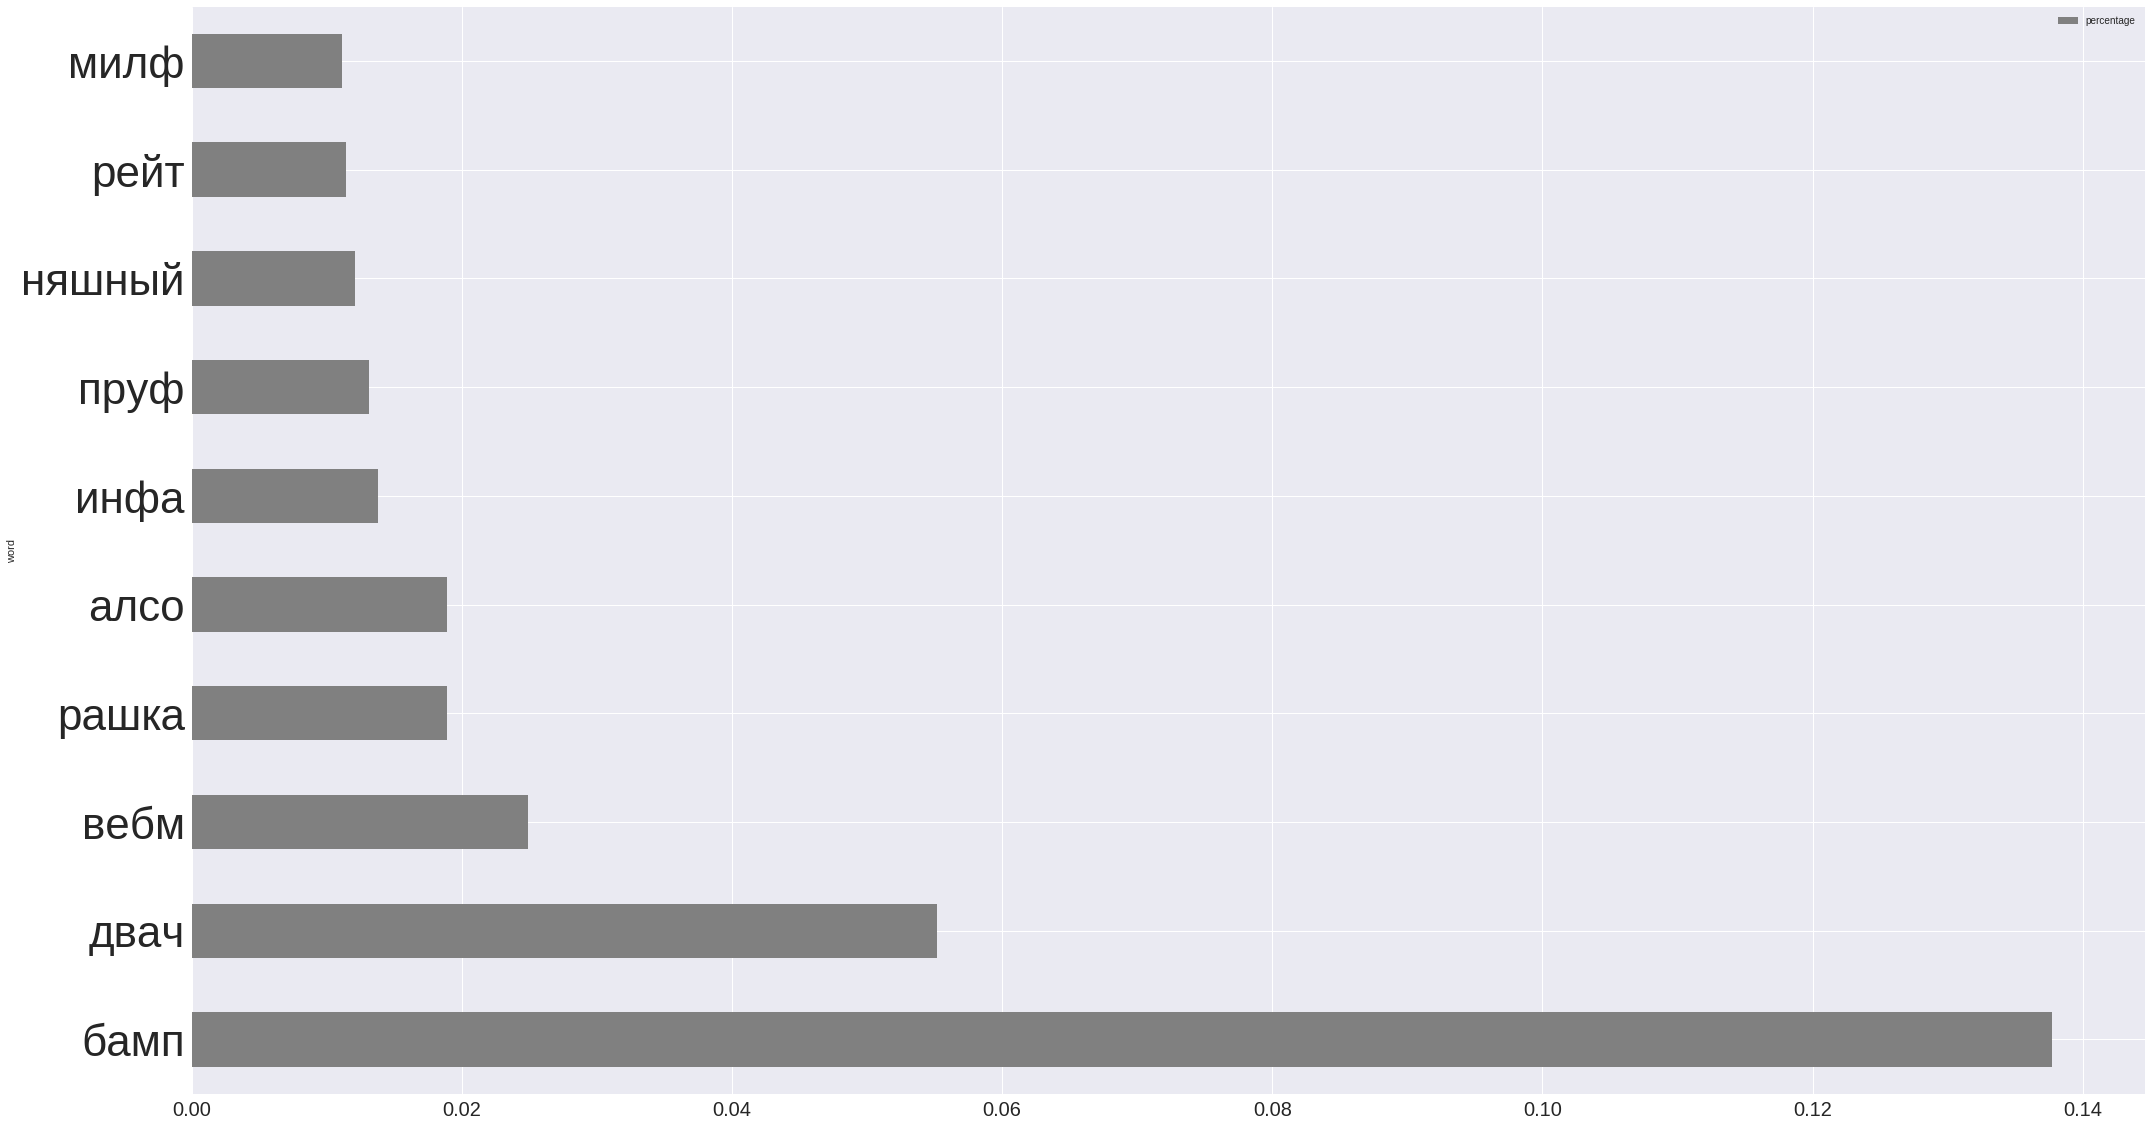

In [73]:
%matplotlib inline

rcParams['figure.figsize'] = 35, 20
params = {'xtick.labelsize': 20, 'ytick.labelsize': 44}
matplotlib.rcParams.update(params)
clrs = ['grey']
df[:10].plot.barh(x='word', y='percentage', color=clrs)
savefig('plot.png', bbox_inches='tight')

In [44]:
model = models.Word2Vec.load('2ch_model')

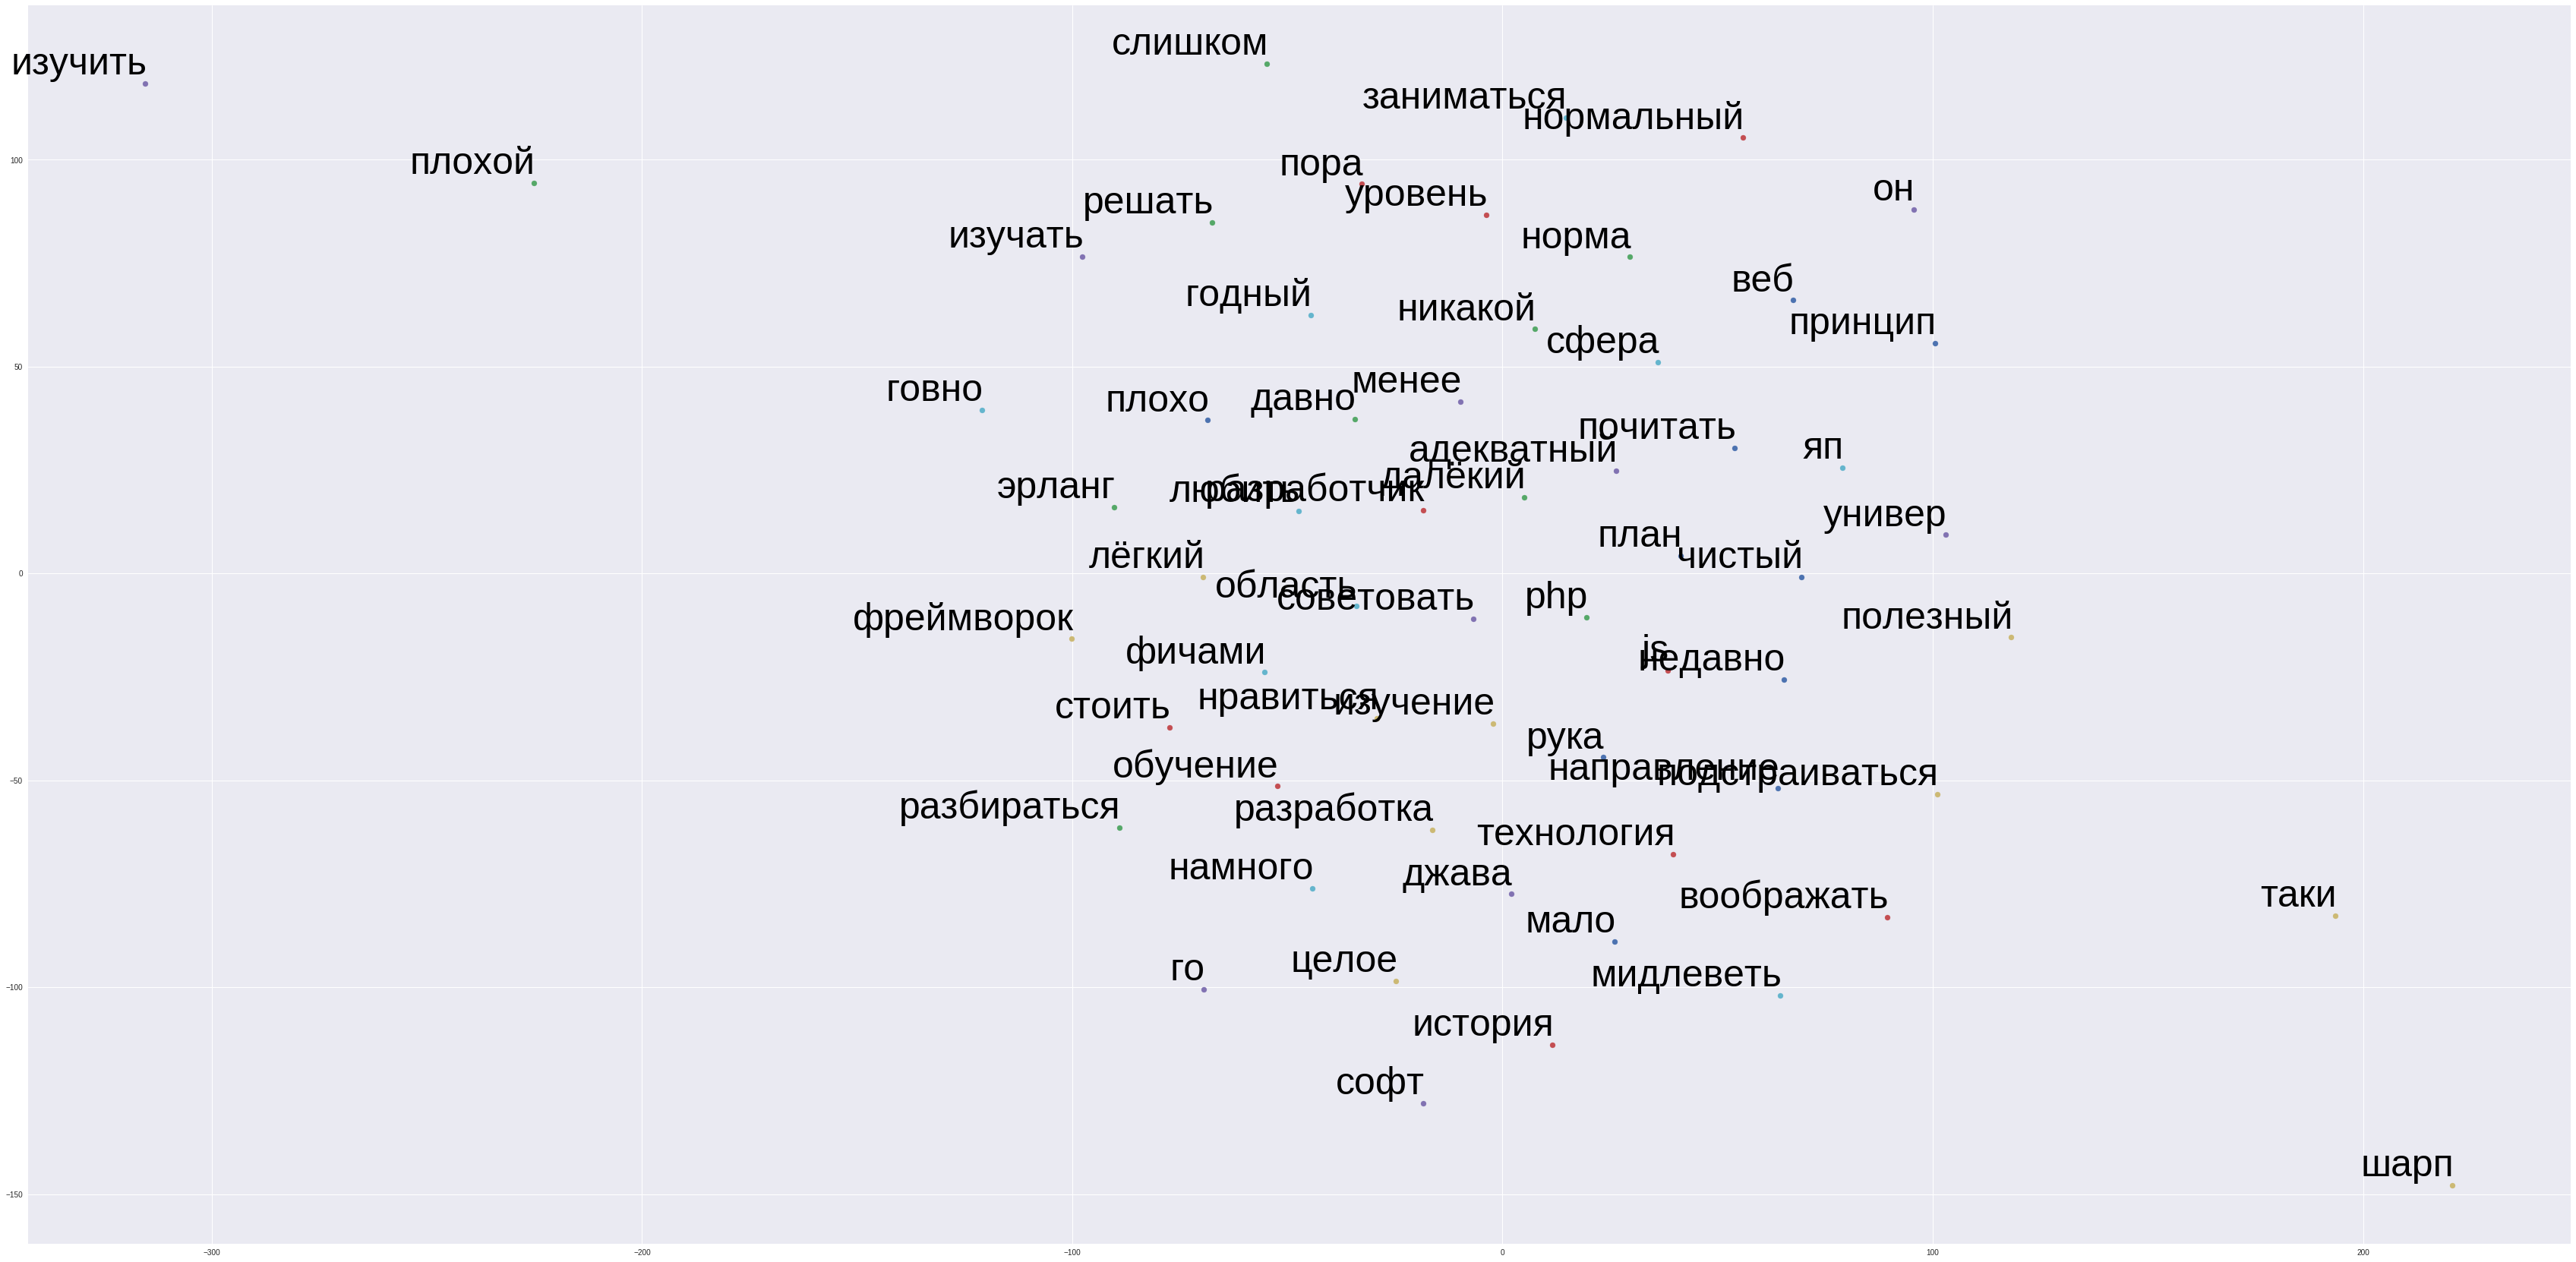

In [89]:
rcParams['figure.figsize'] = 60, 30
params = {'xtick.labelsize': 10, 'ytick.labelsize': 10}
matplotlib.rcParams.update(params)
labels = []
tokens = []

for word in model.most_similar('программирование', topn=60):
    tokens.append(model[word[0]])
    labels.append(word[0])
    
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
        
#plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                fontsize=50,
                color='black',
                xy=(x[i], y[i]),
                xytext=(2, 2),
                textcoords='offset points',
                ha='right',
                va='bottom')
savefig('tsne_plot.png', bbox_inches='tight')